In [1]:
!pip install h5rdmtoolbox==0.9.0

# 1. Planning

- Decide to use HDF5 as your core file format
- Define important attributes and their usage in a metadata convention (e.g. a YAML file)
- Publish your convention on a repository like [Zenodo](https://zenodo.org/)

In [2]:
import h5rdmtoolbox as h5tbx

# Assume we published a convention here: https://zenodo.org/record/8281285
cv = h5tbx.conventions.from_zenodo(doi='8357399')

# enable the convention:
h5tbx.use(cv)

Convention "h5rdmtoolbox-tutorial-convention" filename: C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\cache\10.5281_zenodo.8357399
creating directory for the convention
No special functions defined
Found 0 function(s) in C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\conventions\h5rdmtoolbox_tutorial_convention\h5rdmtoolbox_tutorial_convention.py


using("h5rdmtoolbox-tutorial-convention")

# 2. Collecting

- Fill an HDF5 file with the required data and mandatory metadata
- Data may come in various sources, e.g. from a measurement, a simulation or a database
- HDF5 is best for multidimensional data, but can also be used for 1D data
- When writing the HDF5 files, the convention is automatically validating the metadata input, which are the attributes
  or the datasets and groups


In [3]:
filename = 'my_file.hdf'

import numpy as np

with h5tbx.File(filename,
                mode='w',
                data_type='experimental',
                contact='https://orcid.org/0000-0001-8729-0482') as h5:
    # create a dataset
    h5.create_dataset(name='time', data=np.linspace(0, 1, 1000),
                      standard_name='time', units='ms', make_scale=True)
    h5.create_dataset(name='u',
                      data=np.random.normal(10, 2, 1000),
                      standard_name='x_velocity',
                      units='m/s',
                      attach_scale='time')

# 3. Analyzing

 - Open the file, make computations or just plot the data

In [4]:
import matplotlib.pyplot as plt

with h5tbx.File(filename, mode='r') as h5:
    # inspect the file layout and content:
    h5.dump()

In [5]:
with h5tbx.File(filename, mode='r') as h5:
    u = h5.u[:]
u.attrs.pop('PROVENANCE')  # we remove for brevity of attributes
u

<xarray.DataArray 'u' (time: 1000)>
8.893 13.05 6.669 12.41 6.047 11.26 ... 9.196 9.312 9.205 9.342 11.44 9.049
Coordinates:
  * time     (time) float64 0.0 0.001001 0.002002 0.003003 ... 0.998 0.999 1.0
Attributes:
    standard_name:  x_velocity
    units:          m/s

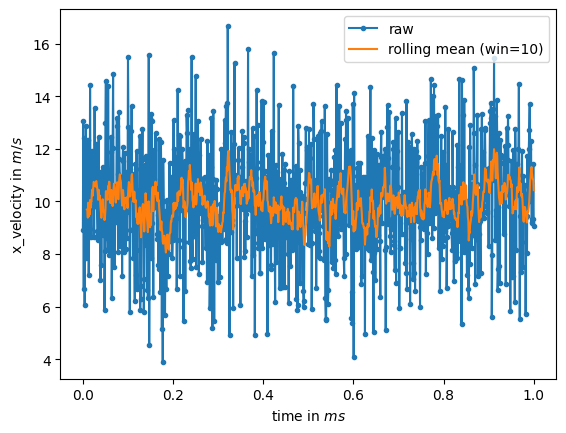

In [6]:
plt.figure()
u.plot(marker='.', label='raw')
u.rolling(time=10).mean().plot(label='rolling mean (win=10)')
plt.legend()
plt.show()

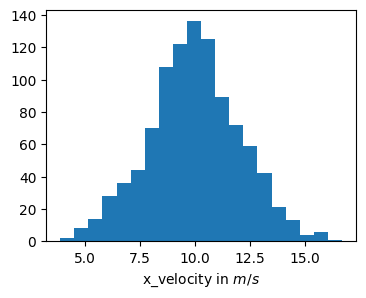

In [7]:
with h5tbx.File(filename, mode='r') as h5:
    plt.figure(figsize=(4, 3))
    h5.u[:].plot.hist(bins=20)
    plt.show()

# 4. Sharing your data
 - The toolbox currently supports storing and querying data to [mongoDB](https://www.mongodb.com/) or to a local file repository.
 - Refer to the [documentation on how to use the mongoDB](https://h5rdmtoolbox.readthedocs.io/en/latest/database/h5mongo.html). For the sake of the example, we do nothing here, as we continue with our local file directory (in our case, this is the temporary directory where we created the file, see above)

In [8]:
# HDF5 file may be moved to another location or into a mongoDB...

# 5. Reusing

 - Find the data by searching through a file director
 - The root folder is the parent of the created file

In [9]:
fdb = h5tbx.database.Folder('.')
fdb

<Folder (root=".", nfiles=1, recursive=True)>

Find exactly one file with "standard_name=x_velocity":

In [10]:
result = fdb.find_one({'standard_name': {'$eq': 'x_velocity'}})
result

<LDataset "/u" in "my_file.hdf" attrs=(units=m/s, standard_name=x_velocity)>

The variable "result" is the found dataset (class is `LDataset`, a wrapper around a closed HDF dataset)

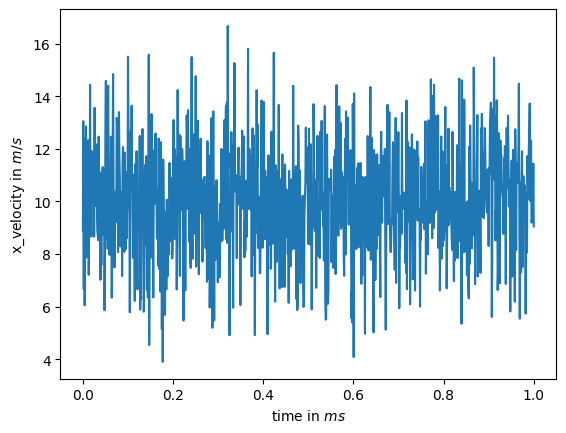

In [11]:
result[:].plot()